In [1]:
# -*- coding: utf-8 -*-
from tensorflow.keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
DATA_DIR = "../data"

MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
# 原本的讀取模式 'rb' 指的是將文件當成二進制文件來讀取; 'rb' causes problems; use 'r'
# 我的修改方式：不要用二進制方式讀取，直接以utf-8編碼的方式讀取進來
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower()) # 因為已經以utf-8編碼方式讀檔，因此不需要再decode
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [3]:
## Get some information about our corpus
#print maxlen            # 42
#print len(word_freqs)   # 2313

# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 featurs to account for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in 
                enumerate(word_freqs.most_common(MAX_FEATURES))}
len(word_freqs)

2268

In [4]:
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [5]:
# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
# 原本的讀取模式 'rb' 指的是將文件當成二進制文件來讀取
# 我的修改方式：不要用二進制方式讀取，直接以utf-8編碼的方式讀取進來
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower()) # 因為已經以utf-8編碼方式讀檔，因此不需要再decode
    seqs = []
    for word in words:
        # 原本的程式碼為：if word2index.has_key(word)
        # https://docs.python.org/3.0/whatsnew/3.0.html#builtins
        # 根據Python官方的公告（參考上方網頁），has_key已經移除了，因此必須改寫成下列方式：
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

In [6]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)
#len(X[0])
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   5,  11,  10,  13, 101,  16,  49,  21,
         4])

In [7]:
# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, 
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


In [8]:
# Build model
model = Sequential()
#model.add(Embedding(vocab_size, EMBEDDING_SIZE, 
#                    input_length=MAX_SENTENCE_LENGTH))
model.add(Embedding(output_dim=EMBEDDING_SIZE, input_dim= vocab_size,
                    input_length=None))
# 原本的程式碼：model.add(SpatialDropout1D(Dropout(0.2)))，會跳出錯誤
# https://github.com/PacktPublishing/Deep-Learning-with-Keras/issues/14
# 網路上有人執行這本書提供的code也有同樣的問題，因此參考上述解答後，把Dropout移除，改成如下：
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
#model.summary()

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7916 - loss: 0.4072 - val_accuracy: 0.9795 - val_loss: 0.0633
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9927 - loss: 0.0240 - val_accuracy: 0.9859 - val_loss: 0.0422
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9859 - val_loss: 0.0476
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9887 - val_loss: 0.0503
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9845 - val_loss: 0.0594
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 0.9901 - val_loss: 0.0327
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9999 - loss: 9.1146e-04 - val_accuracy: 0.9873 - val_loss: 0.0441
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9988 - loss: 0.0022 - val_

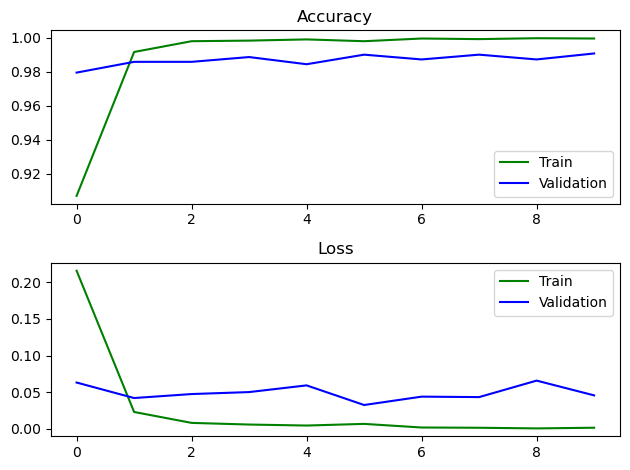

In [10]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [11]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(15):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0353
Test score: 0.046, accuracy: 0.991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
0	0	not because i hate harry potter , but because i am the type of person that likes it when the main character dies .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1	1	brokeback mountain is awesome .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0	0	these harry potter movies really suck .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1	1	i am going to start reading the harry potter series again because that is one awesome story .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1	1	i absolutely love harry potter , as you can tell already .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1	1	i love the harry potter series if you can count that as `` a `` book , also catcher in the tye , jane eyre , the virgin suicides , yeah ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1	1	i love kirsten / leah / kate escapades and mission impossible tom as well ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 40, 128)             │         256,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,189 (3.50 MB)

 Trainable params: 305,729 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 611,460 (2.33 MB)